In [1]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 

import sys, os
parent_dir = os.getcwd()
path = os.path.dirname(parent_dir)
sys.path.append(path)

In [2]:
def process_data(timestamp, algo, pricing):
    if pricing == 'simple':
        pricing_ = 'Simple'
    else:
        pricing_ = 'Complex'
    input_path = f"experiments/logs/Homer_{pricing_}Env/{algo}/{ts}/"
    device_pth = "/home/ds1/w210/home-energy-optimizer/"+"data/debug/device_list.csv"
    devices = pd.read_csv(device_pth)["device_id"].tolist()
    cols = [
        'device_id',
        'no_solar_cumulative_reward', 
        'no_battery_cumulative_reward',
        'sq_cumulative_reward',
        'cumulative_reward',
    ]
    df_list = []
    for device in devices:
        df = pd.read_csv("/home/ds1/w210/home-energy-optimizer/"
                    +input_path+f"{device}_results_array.csv")
        df_list.append(df[cols].tail(1).copy())
    combined_df = pd.concat(df_list)    

    cols2=['no_solar_cumulative_reward','no_battery_cumulative_reward','sq_cumulative_reward','cumulative_reward']
    labels = ['No Solar','Solar Only','Solar and Battery',f'HOMER - {algo.upper()}']
    agg_df = (combined_df[cols2].agg(['mean', 'std']))

    return combined_df, agg_df, labels, cols2

## Simple Price Results

In [79]:
ts = "221203-140125"
algo =  'rainbow'

df, agg_df, labels, cols2 = process_data(ts, algo, 'simple')
df['Homer - DQN'] = df['cumulative_reward']
agg_df

ts = "221204-183143"
algo =  'ppo'

df_ppo, agg_df_ppo, labels_ppo, cols2_ppo = process_data(ts, algo, 'simple')
df_ppo['Homer - PPO'] = df_ppo['cumulative_reward']
agg_df_ppo


ts = "221204-013053"
algo =  'sac'

df_sac, agg_df_sac, labels_sac, cols2_sac = process_data(ts, algo, 'simple')
df_sac['Homer - SAC'] = df_sac['cumulative_reward']

s1 = pd.merge(df, df_ppo[['device_id','Homer - PPO']], how='left')
simple = pd.merge(s1, df_sac[['device_id','Homer - SAC']], how='left')

cols2.append('Homer - PPO')
cols2.append('Homer - SAC')
labels = ['No Solar', 'Solar Only', 'Expert Model', 'HOMER - DQN', 'HOMER - PPO', 'HOMER - SAC']
simple[['no_solar_cumulative_reward', 'no_battery_cumulative_reward', 'sq_cumulative_reward', 'Homer - DQN', 'Homer - PPO', 'Homer - SAC']].agg(['mean', 'std'])

,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,Homer - DQN,Homer - PPO,Homer - SAC
mean,-291.545111,-143.487092,-44.358837,-164.291477,-436.525392,-125.585702
std,187.693396,144.018433,118.927465,143.141953,161.793498,133.686876


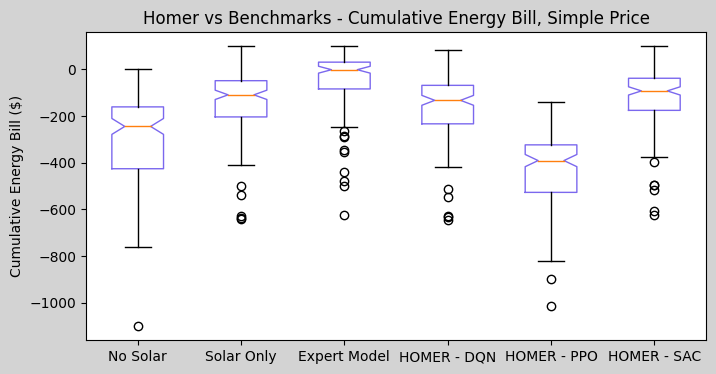

In [80]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_title(f'Homer vs Benchmarks - Cumulative Energy Bill, Simple Price')
ax1.boxplot(simple[cols2], notch = True,boxprops=dict(color='mediumslateblue'))
ax1.set_xticklabels(labels=labels, rotation = 0)
ax1.set_ylabel('Cumulative Energy Bill ($)')
fig1.set_facecolor("lightgrey")
fig1.savefig('simple_aggregated.png', format='png', dpi=150)

In [5]:
simple

,device_id,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,cumulative_reward,Homer - DQN,Homer - PPO,Homer - SAC
0,DD04108401266,-150.926896,-48.618326,25.473007,-63.526641,-63.526641,-289.816318,-40.142774
1,DD04108624381,-476.863932,-139.529819,5.892886,-149.025736,-149.025736,-424.736580,-124.744804
2,DD04108624683,-485.443688,-342.449644,-89.486021,-378.830742,-378.830742,-752.994974,-268.250061
3,DD04108625556,-611.685128,-369.582358,-209.421772,-388.800874,-388.800874,-656.889736,-331.255805
4,DD04108627065,-356.866534,-140.346235,22.437215,-146.813363,-146.813363,-403.038781,-122.610415
...,...,...,...,...,...,...,...,...
144,DDF4108747359,-515.342685,-320.482814,-286.109186,-347.756506,-347.756506,-645.345984,-309.737464
145,ED055CC184C2A,-151.233170,-6.584593,31.489427,-30.778946,-30.778946,-338.221359,-2.008167
146,ED855CC1AF620,-628.787845,-628.677060,-625.632509,-626.489109,-626.489109,-899.536559,-624.013371
147,EDA55CC1AF4FA,-160.143120,-48.524004,34.957348,-59.793726,-59.793726,-360.512688,-38.187083


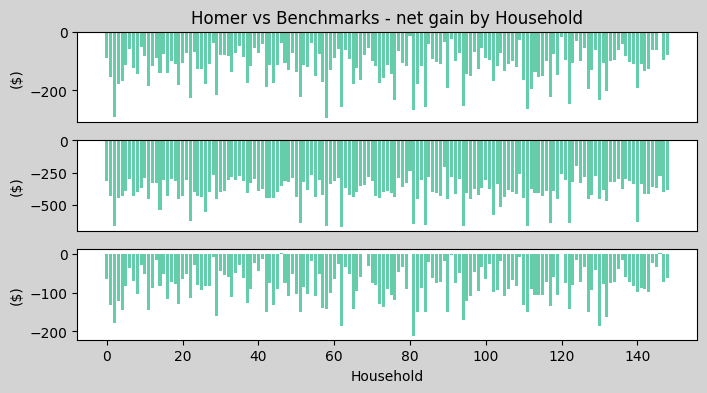

In [74]:
fig1, ax1 = plt.subplots(3, 1, figsize=(8,4))

ax1[0].set_title(f'Homer vs Benchmarks - net gain by Household')
ax1[0].bar(
    x=range(len(df)), 
    height = simple['Homer - DQN'] - simple['sq_cumulative_reward'],
    color='mediumaquamarine'
)
ax1[0].set_ylabel('($)')
ax1[0].get_xaxis().set_visible(False)

ax1[1].bar(
    x=range(len(df)), 
    height = simple['Homer - PPO'] - simple['sq_cumulative_reward'],
    color='mediumaquamarine'
)
ax1[1].set_ylabel('($)')
ax1[1].get_xaxis().set_visible(False)

ax1[2].bar(
    x=range(len(df)), 
    height = simple['Homer - SAC'] - simple['sq_cumulative_reward'],
    color='mediumaquamarine'
)
ax1[2].set_ylabel('($)')
ax1[2].set_xlabel('Household')


fig1.set_facecolor("lightgrey")
fig1.savefig('simple_difference.png', format='png', dpi=150)

In [7]:
# Number of devices which beat the Expert Model. 
len(simple[simple['Homer - SAC'] - simple['sq_cumulative_reward']>0])

3

## Complex

In [64]:
ts = "221205-212606"
#ts = "221206-203201"
algo =  'sac'

df, agg_df, labels, cols2 = process_data(ts, algo, 'complex')
agg_df

,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,cumulative_reward
mean,-9.260075,-3.573082,-1.887660,-2.486483
std,6.229263,6.266988,5.988339,7.181222


In [65]:
df

,device_id,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,cumulative_reward
8928,DD04108401266,-6.423686,-0.789535,1.074449,-0.789535
8928,DD04108624381,-9.425300,-0.973179,0.849766,-0.985006
8928,DD04108624683,-11.323675,-2.600579,-1.506786,7.354867
8928,DD04108625556,-17.079044,-11.167830,-8.939640,-11.100307
8928,DD04108627065,-9.925250,-2.183843,0.981730,-2.154637
...,...,...,...,...,...
8928,DDF4108747359,-14.693803,-10.671038,-10.401810,-10.678491
8928,ED055CC184C2A,-2.595396,3.327938,3.399486,3.375907
8928,ED855CC1AF620,-13.850278,-13.848054,-13.617014,-13.811382
8928,EDA55CC1AF4FA,-5.372850,-0.486475,1.506483,-0.407907


In [66]:
cols2

['no_solar_cumulative_reward',
 'no_battery_cumulative_reward',
 'sq_cumulative_reward',
 'cumulative_reward']

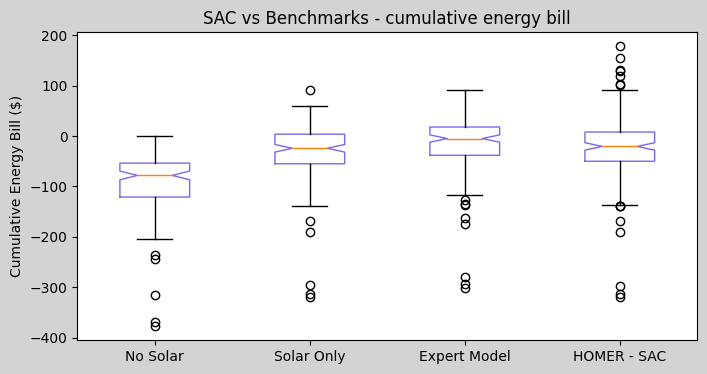

In [78]:
labels = ['No Solar', 'Solar Only', 'Expert Model', 'HOMER - SAC',]
fig1, ax1 = plt.subplots(figsize=(8,4))
ax1.set_title(f'{algo.upper()} vs Benchmarks - cumulative energy bill')
ax1.boxplot(df[cols2] * 1000 / 100, notch = True,boxprops=dict(color='mediumslateblue'))
ax1.set_xticklabels(labels=labels, rotation = 0)
ax1.set_ylabel('Cumulative Energy Bill ($)')
fig1.set_facecolor("lightgrey")
fig1.savefig('complex_aggregated.png', format='png', dpi=150)

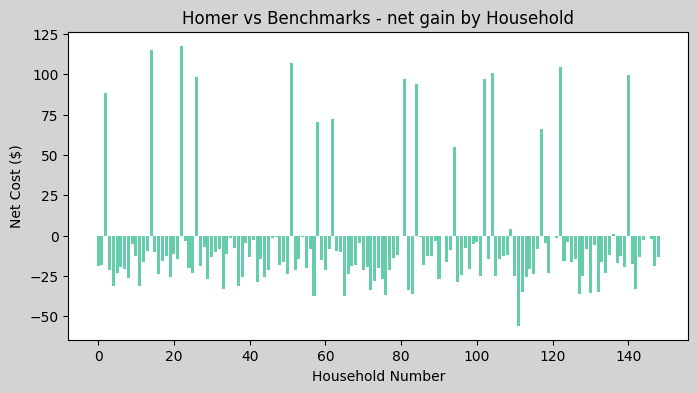

In [76]:
plt.figure(facecolor='lightgrey',figsize=(8,4)
          )
plt.bar(
    x=range(len(df)), 
    height = (df['cumulative_reward'] - df['sq_cumulative_reward']) * 1000 / 100,
    color='mediumaquamarine'
)
plt.title('Homer vs Benchmarks - net gain by Household')
plt.ylabel("Net Cost ($)")
plt.xlabel("Household Number")
plt.savefig('complex_difference.png', format='png', dpi=150)

#ax = plt.axes()
#ax.set_facecolor("lightgrey")

In [61]:
df['net']= df['cumulative_reward']-df['sq_cumulative_reward']

In [62]:
metadata = pd.read_csv('../../home-energy-data/data/device_metadata.csv')
state_count = metadata.groupby('State').agg('count')
counts = state_count['DeviceID'].values
merged = pd.merge(df, metadata, left_on='device_id', right_on='DeviceID', how='left')
merged['positive'] = merged['net']>0
merged_agg1 = merged.groupby('State').agg(sum)
positive = merged_agg1.positive.values
region_summary = merged.groupby(['State']).agg('mean')[['no_solar_cumulative_reward', 'no_battery_cumulative_reward',
       'sq_cumulative_reward', 'cumulative_reward', 'net']]

region_summary['N Success'] = positive
region_summary['Total Households'] = counts
region_summary[['N Success','Total Households']].reset_index()


/tmp/ipykernel_32256/1877213355.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_agg1 = merged.groupby('State').agg(sum)
/tmp/ipykernel_32256/1877213355.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region_summary = merged.groupby(['State']).agg('mean')[['no_solar_cumulative_reward', 'no_battery_cumulative_reward',


,State,N Success,Total Households
0,NSW,74,128
1,QLD,7,20
2,SA,4,19
3,VIC,52,64


In [63]:
merged[(merged['net']>0 ) & (merged['State']=='SA')]

,device_id,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,cumulative_reward,net,DeviceID,SiteType,Postcode,State,SiteID,InstallationDate,positive
2,DD04108624683,-636.522613,-15.059454,-55.068047,-49.080034,5.988013,DD04108624683,Single Phase,5018,SA,Not provided,7-Sep-21,True
81,DD84108399362,-640.542430,160.468873,120.160981,126.370310,6.209328,DD84108399362,Single Phase,5115,SA,Not provided,19-Jul-21,True
94,DDA4108411830,-592.309551,103.684416,70.148894,70.862180,0.713286,DDA4108411830,Single Phase,5064,SA,Not provided,21-Apr-21,True
122,DDD4108400047,-656.294540,275.483946,240.752865,242.723059,1.970195,DDD4108400047,Single Phase,5095,SA,Not provided,29-Jul-21,True


In [17]:
# Get price data
def process_all_data(timestamp, algo, pricing):
    if pricing == 'simple':
        pricing_ = 'Simple'
    else:
        pricing_ = 'Complex'
    input_path = f"experiments/logs/Homer_{pricing_}Env/{algo}/{ts}/"
    device_pth = "/home/ds1/w210/home-energy-optimizer/"+"data/debug/device_list.csv"
    devices = pd.read_csv(device_pth)["device_id"].tolist()
    df_list = []
    for device in devices:
        df = pd.read_csv("/home/ds1/w210/home-energy-optimizer/"
                    +input_path+f"{device}_results_array.csv")
        df_list.append(df.copy())
    combined_df = pd.concat(df_list)    

    return combined_df

full_df = process_all_data("221205-212606", 'sac', 'complex')

In [18]:
VIC = full_df[full_df['device_id']=='DDB4108743355'][['Datetime','export_tariff']]
NSW = full_df[full_df['device_id']=='DDE4108626592'][['Datetime','export_tariff']]
SA =  full_df[full_df['device_id']=='DD04108624683'][['Datetime','export_tariff']]

price_df = pd.merge(VIC, NSW, on='Datetime', how='left')
price_df = pd.merge(price_df, SA, on='Datetime', how='left')
price_df.columns = ['Datetime', 'VIC', 'NSW', 'SA']
dt= price_df['Datetime']
vic= price_df['VIC']
nsw= price_df['NSW']
sa= price_df['SA']

In [19]:
price_df = pd.merge(VIC, NSW, on='Datetime', how='left')
price_df = pd.merge(price_df, SA, on='Datetime', how='left')
price_df.columns = ['Datetime', 'VIC', 'NSW', 'SA']
dt= price_df[['Datetime','SA']]

In [20]:
datetime.strptime(dt['Datetime'].loc[0], '%Y-%m-%d %H:%M:%S%z')

NameError: name 'datetime' is not defined

In [21]:
from datetime import datetime

dev = 'DD84108399362'#'DD04108624683'#'DDD4108400047'#'DD94108411897'#,'DD34108399074'#'DD84108399362'#'DD54108397703'#'DD04108624683'
start = datetime.strptime("26/08/22 00:00:00+1000", '%d/%m/%y %H:%M:%S%z')
end = datetime.strptime("27/08/22 00:00:00+1000", '%d/%m/%y %H:%M:%S%z')

filter_ = (dt['Datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z'))>= start) & (dt['Datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z'))<= end)
dt=dt[filter_]

example_df = full_df[full_df['device_id']==f'{dev}']

example_filter = (example_df['Datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z'))>= start) & (example_df['Datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z'))<= end)
example_df = example_df[example_filter]

In [22]:
example_df

,index,Datetime,Timestamp,time_x,time_y,weekday,month_x,month_y,region_1,region_2,...,env_epochs,cumulative_reward,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,sq_soc,sq_net,sq_updated_action,sq_bat_output,device_id
7200,7200,2022-08-26 00:00:00+10:00,1661436000,1.000000,0.000000,0.0,-0.5,-0.866025,0.0,0.0,...,1,-2.975167,-9.809086,-3.264542,-0.653661,0.412814,0.0,-0.017400,-0.00725,DD84108399362
7201,7201,2022-08-26 00:05:00+10:00,1661436300,0.999762,0.021815,0.0,-0.5,-0.866025,0.0,0.0,...,1,-2.975353,-9.809271,-3.264728,-0.653661,0.412264,0.0,-0.017544,-0.00731,DD84108399362
7202,7202,2022-08-26 00:10:00+10:00,1661436600,0.999048,0.043619,0.0,-0.5,-0.866025,0.0,0.0,...,1,-2.975583,-9.809502,-3.264958,-0.653661,0.411709,0.0,-0.017688,-0.00737,DD84108399362
7203,7203,2022-08-26 00:15:00+10:00,1661436900,0.997859,0.065403,0.0,-0.5,-0.866025,0.0,0.0,...,1,-2.975826,-9.809744,-3.265201,-0.653661,0.411136,0.0,-0.018240,-0.00760,DD84108399362
7204,7204,2022-08-26 00:20:00+10:00,1661437200,0.996195,0.087156,0.0,-0.5,-0.866025,0.0,0.0,...,1,-2.976123,-9.810041,-3.265498,-0.653661,0.410257,0.0,-0.028008,-0.01167,DD84108399362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7484,7484,2022-08-26 23:40:00+10:00,1661521200,0.996195,-0.087156,0.0,-0.5,-0.866025,0.0,0.0,...,1,9.435417,-11.836622,-2.792441,-0.036764,0.196113,0.0,-0.083520,-0.03480,DD84108399362
7485,7485,2022-08-26 23:45:00+10:00,1661521500,0.997859,-0.065403,0.0,-0.5,-0.866025,0.0,0.0,...,1,9.434421,-11.837619,-2.793437,-0.036764,0.193406,0.0,-0.086232,-0.03593,DD84108399362
7486,7486,2022-08-26 23:50:00+10:00,1661521800,0.999048,-0.043619,0.0,-0.5,-0.866025,0.0,0.0,...,1,9.433535,-11.838505,-2.794324,-0.036764,0.190741,0.0,-0.084936,-0.03539,DD84108399362
7487,7487,2022-08-26 23:55:00+10:00,1661522100,0.999762,-0.021815,0.0,-0.5,-0.866025,0.0,0.0,...,1,9.432724,-11.839316,-2.795135,-0.036764,0.188262,0.0,-0.078984,-0.03291,DD84108399362


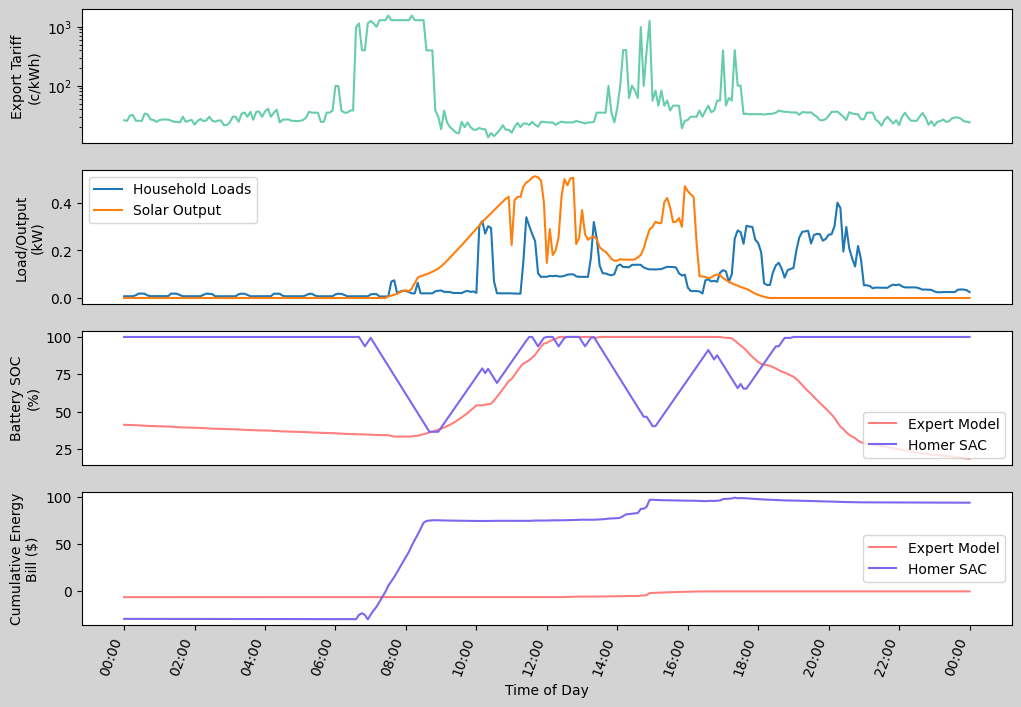

In [77]:
fig2, ax1 = plt.subplots(4, 1, figsize=(12,8))

# Price
ax1[0].plot(dt['Datetime'], dt['SA']*1000, color='mediumaquamarine')
ax1[0].get_xaxis().set_visible(False)
ax1[0].set_ylabel('Export Tariff\n(c/kWh)')
ax1[0].set_yscale('log')

l11, =ax1[1].plot(example_df['Datetime'], example_df['loads'], label='Household Loads')
l12, = ax1[1].plot(example_df['Datetime'], example_df['solar'] * -1, label='Solar Output')
ax1[1].set_ylabel('Load/Output\n(kW)')
ax1[1].get_xaxis().set_visible(False)
ax1[1].legend(handles=[l11, l12])

l21, = ax1[2].plot(example_df['Datetime'], example_df['sq_soc'] * 100, color='red', alpha=0.5, label='Expert Model')
l22, = ax1[2].plot(example_df['Datetime'], example_df['soc']* 100, color='mediumslateblue', label='Homer SAC')
ax1[2].set_ylabel('Battery SOC\n(%)')
ax1[2].get_xaxis().set_visible(False)
ax1[2].legend(handles=[l21, l22], loc=4)

times = example_df['Datetime'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S%z').time().strftime("%H:%M"))
l31, = ax1[3].plot(example_df['Datetime'], example_df['sq_cumulative_reward'] * 1000 / 100, color='red', alpha=0.5, label='Expert Model')
l32, = ax1[3].plot(example_df['Datetime'], example_df['cumulative_reward'] * 1000 / 100, color='mediumslateblue', label='Homer SAC')
ax1[3].set_ylabel('Cumulative Energy\nBill ($)')
ax1[3].legend(handles=[l31, l32], loc=7)
ax1[3].set_xlabel('Time of Day')
ax1[3].set_xticks(example_df['Datetime'][::24])
ax1[3].set_xticklabels(times[::24], rotation=70, ha='right')
#ax1[3].set_yscale('log')

fig2.set_facecolor("lightgrey")
fig2.savefig('detailed_analysis.png', format='png', dpi=150)

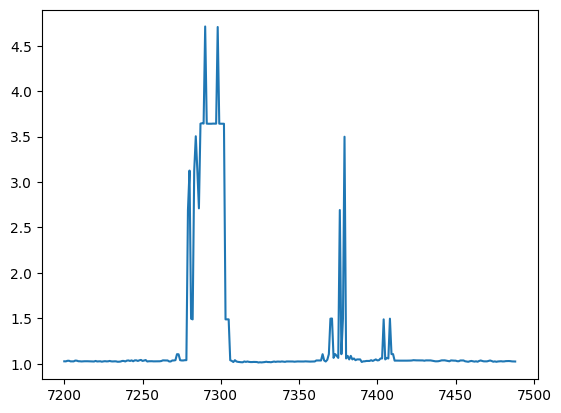

In [45]:
a = dt['SA']
a = np.exp(a)
plt.plot(a)

In [215]:
full_df[full_df['device_id'] == 'DD04108401266'].sort_values(by='Timestamp')

,index,Datetime,Timestamp,time_x,time_y,weekday,month_x,month_y,region_1,region_2,...,env_epochs,cumulative_reward,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,sq_soc,sq_net,sq_updated_action,sq_bat_output,device_id
0,0,2022-08-01 00:00:00+10:00,1659276000,1.000000,0.000000,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.000336,-0.000336,-0.000336,-0.000336,1.000000,0.02328,0.000000,0.00000,DD04108401266
1,1,2022-08-01 00:05:00+10:00,1659276300,0.999762,0.021815,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.000480,-0.000480,-0.000480,-0.000336,0.998521,0.00000,-0.047160,-0.01965,DD04108401266
2,2,2022-08-01 00:10:00+10:00,1659276600,0.999048,0.043619,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.000621,-0.000621,-0.000621,-0.000336,0.997063,0.00000,-0.046464,-0.01936,DD04108401266
3,3,2022-08-01 00:15:00+10:00,1659276900,0.997859,0.065403,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.000763,-0.000763,-0.000763,-0.000336,0.995602,0.00000,-0.046560,-0.01940,DD04108401266
4,4,2022-08-01 00:20:00+10:00,1659277200,0.996195,0.087156,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.000854,-0.000854,-0.000854,-0.000336,0.994148,0.00000,-0.046344,-0.01931,DD04108401266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,8924,2022-08-31 23:40:00+10:00,1661953200,0.996195,-0.087156,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.788025,-6.422175,-0.788025,1.074449,0.754194,0.00000,-0.062376,-0.02599,DD04108401266
8925,8925,2022-08-31 23:45:00+10:00,1661953500,0.997859,-0.065403,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.788351,-6.422502,-0.788351,1.074449,0.752827,0.00000,-0.043536,-0.01814,DD04108401266
8926,8926,2022-08-31 23:50:00+10:00,1661953800,0.999048,-0.043619,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.788739,-6.422890,-0.788739,1.074449,0.751204,0.00000,-0.051720,-0.02155,DD04108401266
8927,8927,2022-08-31 23:55:00+10:00,1661954100,0.999762,-0.021815,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,1,-0.789159,-6.423309,-0.789159,1.074449,0.749531,0.00000,-0.053328,-0.02222,DD04108401266


In [221]:
os.getcwd()

'/home/ds1/w210/home-energy-optimizer/experiments'

In [226]:
len(pd.read_parquet(
    '/home/ds1/w210/home-energy-data/data/data_complex/price_and_energy_complex_test/DD04108401266_complex_test.parquet')
    )

8929

In [46]:
f = pd.read_parquet(
    '/home/ds1/w210/home-energy-optimizer/data/complex_pricing/test/original/DD04108401266_complex_test.parquet')

In [ ]:
def get_shortened_df_list(df_concat):
    shortened_df_list = []
    
    for device_id in df_concat.device_id.unique():
        ith_df = df_concat[df_concat["device_id"] == device_id].copy()

        last_datetime = pd.to_datetime(ith_df.Datetime.tail(1).iloc[0])
        last_day = (last_datetime.year, last_datetime.month, last_datetime.day)

        # day
        temp_df = ith_df
        day_list = []

        for timestamp in ith_df.Datetime:
            current_datetime = pd.to_datetime(timestamp)
            current_day = (current_datetime.year, current_datetime.month, current_datetime.day)
            day_list.append(current_day)

        ith_df['day'] = day_list

        # bool remove the last day
        omit_last_day_bool = ith_df['day'] != last_day
        ith_shortened_df = ith_df[omit_last_day_bool]

        shortened_df_list.append(ith_shortened_df) 
        
        print("Completed: ", device_id)
        
    return shortened_df_list

select_df = full_df[['Datetime', 'device_id', 'no_solar_cumulative_reward','no_battery_cumulative_reward','sq_cumulative_reward', 'cumulative_reward']]
SAC_shortened_list = get_shortened_df_list(select_df)
df_SAC_concat_export = pd.concat(SAC_shortened_list)
full_df = pd.merge(full_df, metadata[['DeviceID','State']], left_on='device_id', right_on='DeviceID', how='left')


In [210]:
full_df

,index,Datetime,Timestamp,time_x,time_y,weekday,month_x,month_y,region_1,region_2,...,no_solar_cumulative_reward,no_battery_cumulative_reward,sq_cumulative_reward,sq_soc,sq_net,sq_updated_action,sq_bat_output,device_id,DeviceID,State
0,0,2022-08-01 00:00:00+10:00,1659276000,1.000000,0.000000,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,-0.000336,-0.000336,-0.000336,1.000000,0.02328,0.000000,0.00000,DD04108401266,DD04108401266,VIC
1,1,2022-08-01 00:05:00+10:00,1659276300,0.999762,0.021815,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,-0.000480,-0.000480,-0.000336,0.998521,0.00000,-0.047160,-0.01965,DD04108401266,DD04108401266,VIC
2,2,2022-08-01 00:10:00+10:00,1659276600,0.999048,0.043619,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,-0.000621,-0.000621,-0.000336,0.997063,0.00000,-0.046464,-0.01936,DD04108401266,DD04108401266,VIC
3,3,2022-08-01 00:15:00+10:00,1659276900,0.997859,0.065403,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,-0.000763,-0.000763,-0.000336,0.995602,0.00000,-0.046560,-0.01940,DD04108401266,DD04108401266,VIC
4,4,2022-08-01 00:20:00+10:00,1659277200,0.996195,0.087156,0.0,-5.000000e-01,-0.866025,1.0,0.0,...,-0.000854,-0.000854,-0.000336,0.994148,0.00000,-0.046344,-0.01931,DD04108401266,DD04108401266,VIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330416,8924,2022-08-31 23:40:00+10:00,1661953200,0.996195,-0.087156,0.0,-5.000000e-01,-0.866025,0.0,0.0,...,-3.701131,1.537856,2.890149,0.822767,0.00000,-0.033264,-0.01386,EDB55CC1AF417,EDB55CC1AF417,NSW
1330417,8925,2022-08-31 23:45:00+10:00,1661953500,0.997859,-0.065403,0.0,-5.000000e-01,-0.866025,0.0,0.0,...,-3.701224,1.537762,2.890149,0.822309,0.00000,-0.014592,-0.00608,EDB55CC1AF417,EDB55CC1AF417,NSW
1330418,8926,2022-08-31 23:50:00+10:00,1661953800,0.999048,-0.043619,0.0,-5.000000e-01,-0.866025,0.0,0.0,...,-3.701394,1.537593,2.890149,0.821473,0.00000,-0.026640,-0.01110,EDB55CC1AF417,EDB55CC1AF417,NSW
1330419,8927,2022-08-31 23:55:00+10:00,1661954100,0.999762,-0.021815,0.0,-5.000000e-01,-0.866025,0.0,0.0,...,-3.701602,1.537384,2.890149,0.820485,0.00000,-0.031488,-0.01312,EDB55CC1AF417,EDB55CC1AF417,NSW
